In [29]:
import torch
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt

In [30]:
random_seed=0

In [31]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Charter"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = (
    r"\usepackage[bitstream-charter]{mathdesign} \usepackage{amsmath} \usepackage{siunitx}"
)

FONTSIZE = 20
FONTSIZE_LEGEND = FONTSIZE
FONTSIZE_TICK = FONTSIZE
TICKLABELSIZE = 10

colors = ["black", "#0343DE", "#A52A2A", "darkorange"]

In [32]:
data = ef.zjets_delphes.load("Herwig", num_data=-1, pad=True, cache_dir='../data/zplusjets/',
                                       source='zenodo', which='all',
                                       include_keys=['mults'])

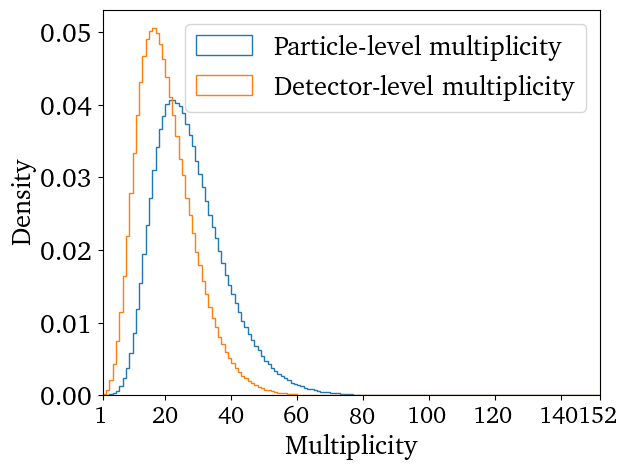

In [33]:
bins = np.arange(1,153)
plt.hist(data["gen_mults"], bins=bins, label='Particle-level multiplicity', histtype='step', density=True)
plt.hist(data["sim_mults"], bins=bins, label='Detector-level multiplicity', histtype='step', density=True)
plt.legend(fontsize=FONTSIZE_LEGEND)
plt.xlim(1,152)
plt.xticks([1,152] + list(range(20,152,20)), fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('Multiplicity', fontsize=FONTSIZE)
plt.ylabel('Density', fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('plots/hist_mult.pdf')

In [34]:
true_diff = data['gen_mults'] - data['sim_mults']

In [35]:
print(true_diff.min(), true_diff.max())

-53 78


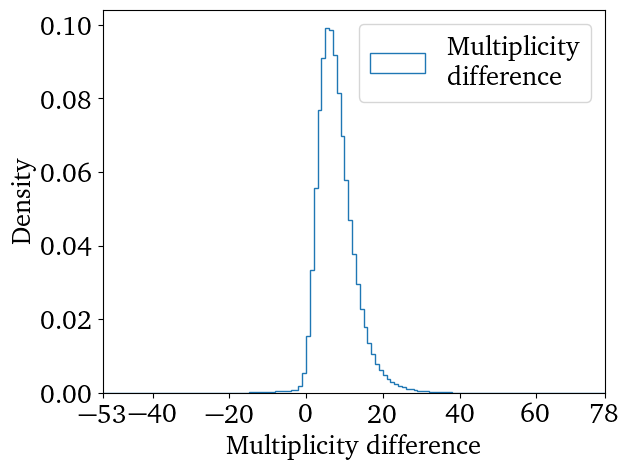

In [36]:
bins = np.arange(-53,79)
plt.hist(true_diff, bins=bins, label='Multiplicity\n difference', histtype='step', density=True)
plt.legend(fontsize=FONTSIZE_LEGEND, loc='upper right')
plt.yticks(fontsize=FONTSIZE_TICK)
plt.xlim(-53,78)
plt.xticks([-53, 78] + list(range(-40,78,20)), fontsize=FONTSIZE_TICK)
plt.xlabel('Multiplicity difference', fontsize=FONTSIZE)
plt.ylabel('Density', fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('plots/hist_mult_diff.pdf')

In [53]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Reshape true_diff to 2D array for GaussianMixture
X = data['gen_mults'].reshape(-1, 1)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=12)
gmm.fit(X)

GaussianMixture(n_components=3, random_state=12)

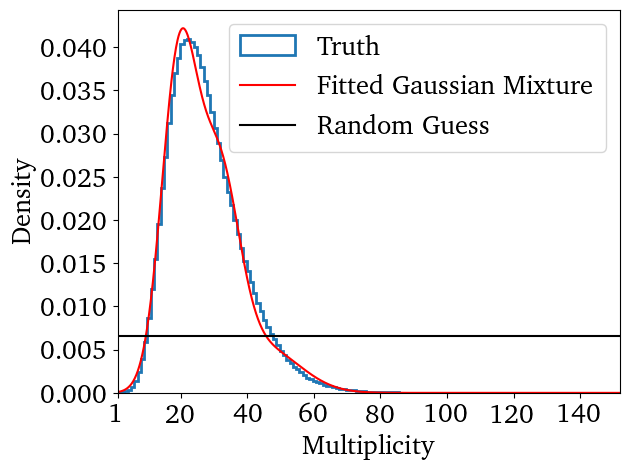

In [54]:
# Generate points for plotting the fitted distribution
x = np.linspace(min(data['gen_mults']), max(data['gen_mults']), 1000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

# Plot histogram of true data and fitted mixture
plt.hist(data['gen_mults'], bins=max(data['gen_mults']) - min(data['gen_mults']) + 1, density=True, label='Truth', histtype='step', linewidth=2)
plt.plot(x, y, 'r-', label='Fitted Gaussian Mixture', linewidth=1.5)
plt.plot((min(data['gen_mults']),max(data['gen_mults'])), (1/(max(data['gen_mults'])-min(data['gen_mults'])+1), 1/(max(data['gen_mults'])-min(data['gen_mults'])+1)), 'k-', label='Random Guess')
plt.xlabel('Multiplicity', fontsize=FONTSIZE)
plt.ylabel('Density', fontsize=FONTSIZE)
#plt.title('Histogram with Fitted Gaussian Mixture')
plt.xlim(1,152)
plt.xticks([1]+list(range(20,152,20)), fontsize=FONTSIZE_TICK)
plt.yticks(fontsize=FONTSIZE_TICK)
plt.legend(fontsize=FONTSIZE_LEGEND)
plt.tight_layout()
plt.savefig('plots/baseline_fit.pdf')

In [39]:
-gmm.score_samples(X).mean()

3.7566566580411855

In [50]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Reshape true_diff to 2D array for GaussianMixture
X = true_diff.reshape(-1, 1)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=12)
gmm.fit(X)

GaussianMixture(n_components=3, random_state=12)

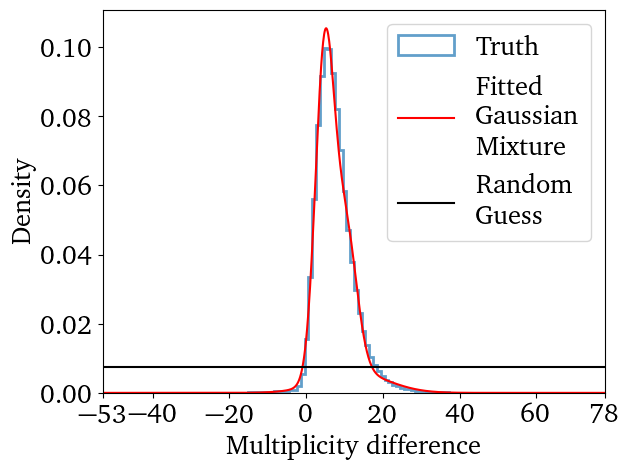

In [51]:
# Generate points for plotting the fitted distribution
x = np.linspace(min(true_diff), max(true_diff), 1000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

# Plot histogram of true data and fitted mixture
plt.hist(true_diff, bins=max(true_diff) - min(true_diff) + 1, density=True, alpha=0.7, label='Truth', histtype='step', linewidth=2)
plt.plot(x, y, 'r-', label='Fitted\nGaussian\nMixture', linewidth=1.5)
plt.plot((min(true_diff),max(true_diff)), (1/(max(true_diff)-min(true_diff)+1), 1/(max(true_diff)-min(true_diff)+1)), 'k-', label='Random\nGuess')
plt.xlabel('Multiplicity difference', fontsize=FONTSIZE)
plt.ylabel('Density', fontsize=FONTSIZE)
#plt.title('Histogram with Fitted Gaussian Mixture')
plt.xlim(-53,78)
plt.xticks([-53, 78] + list(range(-40,78,20)), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('plots/baseline_diff_fit.pdf')

In [42]:
results = -gmm.score_samples(X)

In [43]:
results.shape

(1686956,)

In [44]:
results.mean()

2.928100590254376

In [45]:
print(f"Mean: {np.mean(results)}")
print(f"Median: {np.median(results)}")
print(f"Std Dev: {np.std(results)}")
print(f"Min: {np.min(results)}")
print(f"Max: {np.max(results)}")
print(f"25th percentile: {np.percentile(results, 25)}")
print(f"75th percentile: {np.percentile(results, 75)}")

Mean: 2.928100590254376
Median: 2.5819822411960596
Std Dev: 0.9346043519144627
Min: 2.252594037606404
Max: 33.9170638691584
25th percentile: 2.345705222073803
75th percentile: 3.004127861675677


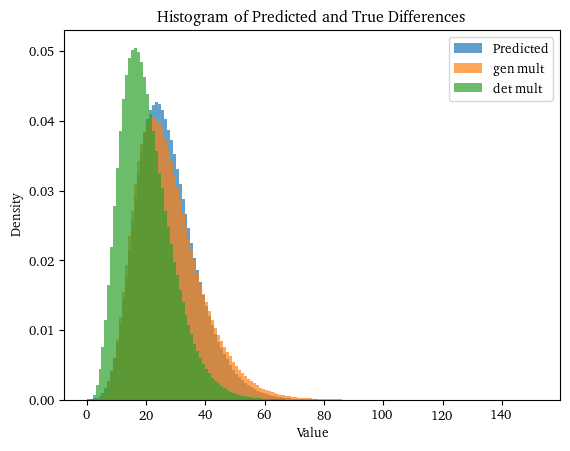

In [46]:
predicted_diff = gmm.sample(n_samples=len(true_diff))[0].flatten()
plt.hist(predicted_diff + data['sim_mults'], bins=np.arange(0,153), density=True, alpha=0.7, label='Predicted')
#plt.hist(predicted_diff, bins=np.arange(0,153), density=True, alpha=0.7, label='Predicted')
plt.hist(data['gen_mults'], bins=np.arange(0,153), density=True, alpha=0.7, label='gen mult')
plt.hist(data['sim_mults'], bins=np.arange(0,153), density=True, alpha=0.7, label='det mult')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted and True Differences')
plt.legend()
plt.show()

In [47]:
seed = np.random.randint(0, 1000)
# Reshape true_diff to 2D array for GaussianMixture
X = true_diff.reshape(-1, 1)
results = []
# Fit Gaussian Mixture Model
for i in range(5):
    gmm = GaussianMixture(n_components=10, random_state=seed+i)
    gmm.fit(X)
    results.append(-gmm.score_samples(X).mean())
    

In [48]:
print(results, np.mean(results), np.std(results))

[1.7806063210384417, 2.9271002071444125, 2.9270752170615393, 2.927052180156227, 1.7700616960033602] 2.466379124280796 0.5642458274720077
